# Basic GP, Marginal Likelihood

In [1]:
%matplotlib inline
import numpy as np
import theano
import theano.tensor as tt
import theano.tensor.nlinalg 
import sys
sys.path.insert(0, "../../..")
import pymc3 as pm

np.random.seed(205)

# define gp, true parameter values
with pm.Model() as model:
    l = 0.2 
    tau = 2.0 
    cov = tau * pm.gp.cov.Exponential(1, l)

n = 30
X = np.sort(np.random.rand(n))[:,None]
K = theano.function([], cov.K(X, X))()

# generate fake data from GP with white noise (with variance sigma2)
sigma2 = 0.1 
y = np.random.multivariate_normal(np.zeros(n), K + sigma2 * np.eye(n))

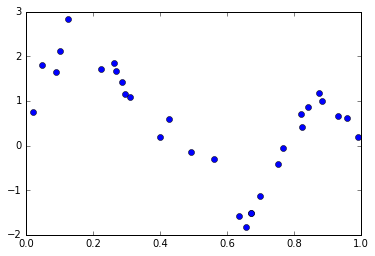

In [2]:
plt.plot(X, y, 'o')

In [3]:
Z = np.linspace(-0.2, 1.2, 100)[:,None]

# infer gp parameter values
with pm.Model() as model:
    l = pm.HalfNormal('l')
    sigma2 = pm.HalfNormal('sigma2')
    tau = pm.HalfNormal('tau')

    f_cov = tau * pm.gp.cov.Matern52(1, l)
    n_cov = sigma2 * tt.eye(n)
    K   = f_cov.K(X, X) + n_cov

    y_obs = pm.MvNormal('y_obs', mu=0.0, cov=K, observed=y)

    # prediction (not required for fitting)
    K_inv = tt.nlinalg.matrix_inverse(K)
    K_s  = f_cov.K(X, Z) 
    K_ss = f_cov.K(Z, Z)
    
    mu = pm.Deterministic("mu", tt.dot(tt.dot(K_s.T, K_inv), y))
    Sigma = pm.Deterministic("Sigma", K_ss - tt.dot(tt.dot(K_s.T, K_inv), K_s))

In [4]:
with model:
    trace = pm.sample(200, init='map', step=pm.Slice())

100%|██████████| 200/200 [00:01<00:00, 145.59it/s]


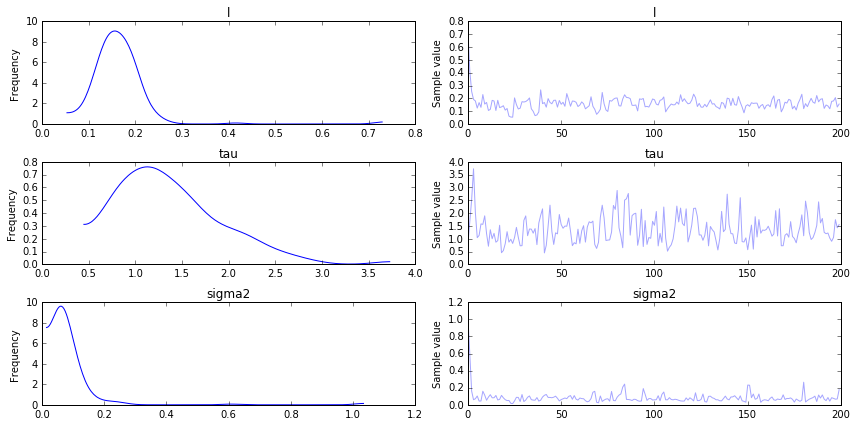

In [6]:
pm.traceplot(trace, varnames=['l', 'tau', 'sigma2']);

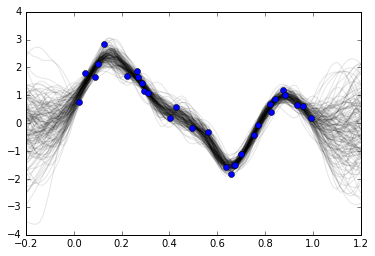

In [8]:
y_pred = [np.random.multivariate_normal(m, S) for m,S in zip(trace['mu'][50:], trace['Sigma'][50:])]

for yp in y_pred:
    plt.plot(Z.flatten(), yp, 'k-', alpha=0.1);
plt.plot(X, y, 'o')